In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
figSize = (8, 6)
SamplingLayer=30
ECAL_layers=60
# Read Data
#Config = ("SumE", "NHits","RecoE_cheat")
#Config = ("SumE", "NHits","RecoE_DGCNN0","RecoE_DGCNN1","RecoE_DGCNN2")
#Config = ("SumE", "NHits","RecoE_MLP")
#Config = ("RecoE_MLP_Huber0.05","RecoE_MLP_Huber0.1","RecoE_MLP_Huber0.15")
Config = ("RecoE_MLP_lr1e-4","RecoE_MLP_lr5e-4","RecoE_MLP_lr1e-3","RecoE_MLP_lr5e-3")
#Config = ("RecoE_MLP_drop0.05","RecoE_MLP_drop0.1","RecoE_MLP_drop0.15")
#Config = ("RecoE_MLP_[256]","RecoE_MLP_[128]","RecoE_MLP_[64]")
#Config = ("RecoE_MLP_WD5e-6","RecoE_MLP_WD1e-5")
#Config = ("SumE", "NHits","RecoE_DGCNN3")
#Config = ("SumE", "NHits","RecoE_cheat","RecoE_MLP0","RecoE_DGCNN0")
#Config = ("SumE", "RecoE_MLP_GELU","RecoE_MLP_Softsign","RecoE_MLP_Res_PReLU")
#Config = ("SumE","NHits","RecoE_MLP","RecoE_MLP_BasicPerformance")
#Config = ("RecoE_MLP_MSE","RecoE_MLP_RelativeMSE","RecoE_MLP_Huber")
#Config = ("SumE","NHits","RecoE_MLP_Layer[64,32,16,8]")
#Config = ("SumE", "NHits")
#Config = ("RecoE_MLP_Fit_Threshold0","RecoE_MLP_Fit_Threshold0.3","RecoE_MLP_Fit_Threshold0.5","RecoE_MLP_Fit_Threshold1.0","RecoE_MLP_Fit_Threshold1.5")
colors = ['blue', 'green', 'red','orange','purple','brown','cyan','magenta']
dataPath = f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer{SamplingLayer}_in{ECAL_layers}/Reco_Results"

particleEnergy = []
meanGamma = []
meanGammaErr = []
peakGamma = []
peakGammaErr = []
resGamma = []
resGammaErr = []

for i_config in range(len(Config)):
    fileName = os.path.join(dataPath, f"{Config[i_config]}_Fit.csv")
    #fileName = os.path.join(dataPath, f"{Config[i_config]}.csv")
    df = pd.read_csv(fileName)
    particleEnergy.append(df["ParticleEnergy"].to_numpy())
    meanGamma.append(df["Mean_Gamma"].to_numpy())
    meanGammaErr.append(df["Mean_Gamma_Error"].to_numpy())
    peakGamma.append(df["Peak_Gamma"].to_numpy())
    peakGammaErr.append(df["Peak_Gamma_Error"].to_numpy())
    resGamma.append(df["Res_Gamma"].to_numpy())
    resGammaErr.append(df["Res_Gamma_Error"].to_numpy())
    print(f"Loaded {fileName}")


Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/Reco_Results/RecoE_MLP_WD5e-6_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/Reco_Results/RecoE_MLP_WD1e-5_Fit.csv


Config: RecoE_MLP_WD5e-6
Config: RecoE_MLP_WD1e-5


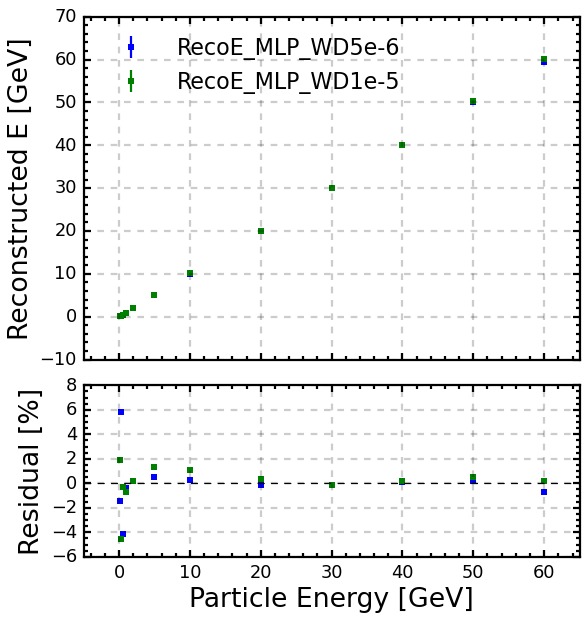

Config: RecoE_MLP_WD5e-6
Config: RecoE_MLP_WD1e-5


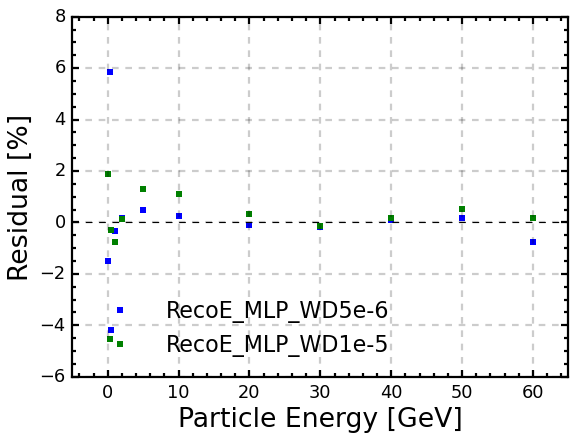

In [63]:

# Linearity and Resolution
def linear_func(x, a, b):
    return a * x + b

def fitAndResidualRatio(x, y, fit_range=(0,70)):
    """Linear fit and return coefficients, fit values, and relative residuals."""
    a0 = (y[-1] - y[0]) / (x[-1] - x[0])
    b0 = y[0]
    p0 = [a0, b0]
    upper_bound = [5*a0, np.inf]
    lower_bound = [0, -np.inf]  # Ensure slope is non-negative
    mask = (x >= fit_range[0]) & (x <= fit_range[1])
    coeffs, cov = curve_fit(linear_func, x[mask], y[mask], p0=p0, bounds=(lower_bound, upper_bound),sigma=x[mask], absolute_sigma=True)
    fitVals = linear_func(x, *coeffs)
    residualRatio = (y - fitVals) / fitVals
    return coeffs, fitVals, residualRatio
fitGamma,ResGamma = [],[]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(figSize[0], figSize[1]*1.5), 
        sharex=True,gridspec_kw={'height_ratios':[1, 0.5],'hspace': 0.1})
MarkerSize = 10
for i_c in range(len(Config)):
    print(f"Config: {Config[i_c]}")
    if Config[i_c] == "NHits":
        fit_range = (0, 0.8)
    else:
        fit_range = (0, 70)
    #Calib
    coeff,fitVals,residualRatio = fitAndResidualRatio(particleEnergy[i_c], peakGamma[i_c], fit_range=fit_range)
    peakGamma[i_c] = (peakGamma[i_c]-coeff[1])/(coeff[0])
    peakGammaErr[i_c] = peakGammaErr[i_c]/(coeff[0])
    coeff,fitVals,residualRatio = fitAndResidualRatio(particleEnergy[i_c], peakGamma[i_c], fit_range=fit_range)
    residualRatio = (peakGamma[i_c] - particleEnergy[i_c]) / particleEnergy[i_c]
    fitGamma.append(fitVals)
    ResGamma.append(residualRatio)
    # Gamma
    ax1.errorbar(particleEnergy[i_c], peakGamma[i_c], yerr=peakGammaErr[i_c],
        fmt='s', capsize=4, label=Config[i_c], color=colors[i_c]
    )
    #ax1.plot(particleEnergy[i_c], fitGamma[i_c], '-', color=colors[i_c])
    ax1.set_ylabel("Reconstructed E [GeV]")
    #ax1.set_ylim(-100, 1300)
    ax1.set_xlim(-5, 65)
    #ax1.set_title("Linearity")
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.2)

    ax2.plot(particleEnergy[i_c], ResGamma[i_c]*100, 's', label='Gamma', color=colors[i_c])

    ax2.axhline(0, color='black', lw=1, linestyle='--')
    ax2.set_xlabel("Particle Energy [GeV]")
    ax2.set_ylabel("Residual [%]")
    ax2.grid(True, linestyle='--', alpha=0.2)
plt.show()

plt.figure(figsize=figSize)

for i_c in range(len(Config)):
    print(f"Config: {Config[i_c]}")
    # 假设 fitGamma 和 ResGamma 已经计算好
    plt.plot(particleEnergy[i_c], ResGamma[i_c]*100, 's', label=Config[i_c], 
             color=colors[i_c])

plt.axhline(0, color='black', lw=1, linestyle='--')
plt.xlabel("Particle Energy [GeV]")
plt.ylabel("Residual [%]")
plt.xlim(-5, 65)
#plt.ylim(-100, 30)
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend(loc='lower left')
plt.show()


/tmp/ipykernel_464182/3124738620.py:6: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sqrt(E)


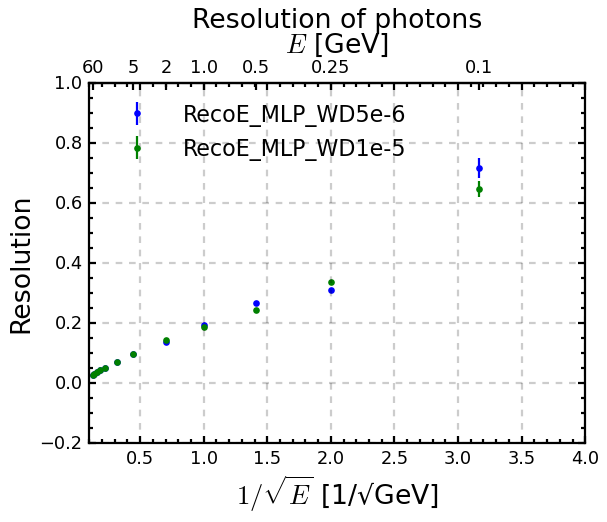

In [64]:
plt.figure(figsize=figSize)
ax = plt.gca()
def forward(x):  # 下轴(1/sqrt(E)) -> 上轴(E)
    return 1 / (x**2)
def inverse(E):  # 上轴(E) -> 下轴(1/sqrt(E))
    return 1 / np.sqrt(E)
secax = ax.secondary_xaxis("top", functions=(forward, inverse))
secax.set_xlabel(r"$E$ [GeV]")
E_ticks = [0.1, 0.25, 0.5, 1.0, 2, 5, 60]
secax.set_xticks(E_ticks)
secax.set_xticklabels(E_ticks)
secax.xaxis.set_minor_locator(plt.NullLocator())  # 禁用所有次刻度
secax.xaxis.set_tick_params(which='both', top=True, labeltop=True, bottom=False, labelbottom=False)
for i_c in range(len(Config)):
    x_vals = 1 / np.sqrt(particleEnergy[i_c])
    ax.errorbar(x_vals, resGamma[i_c], yerr=resGammaErr[i_c],
                fmt='o', capsize=4, label=Config[i_c], color=colors[i_c])
ax.set_xlabel(r"$1/\sqrt{E}$ [1/√GeV]")
ax.set_ylabel("Resolution")
ax.set_title("Resolution of photons", pad=50)
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_xlim(0.1, 4)
plt.show()

    

Config: RecoE_MLP_WD5e-6
y_vals: [0.71752058 0.3096964  0.26612455 0.19439777 0.13727172 0.09783579
 0.07014159 0.05144371 0.04306975 0.0370951  0.03151069 0.02786246]
Config: RecoE_MLP_WD1e-5
y_vals: [0.64662046 0.33754885 0.24518537 0.18619269 0.14239442 0.09685218
 0.0703827  0.05073927 0.04238861 0.03638252 0.03164254 0.0282687 ]


/tmp/ipykernel_464182/2278701223.py:10: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sqrt(E)


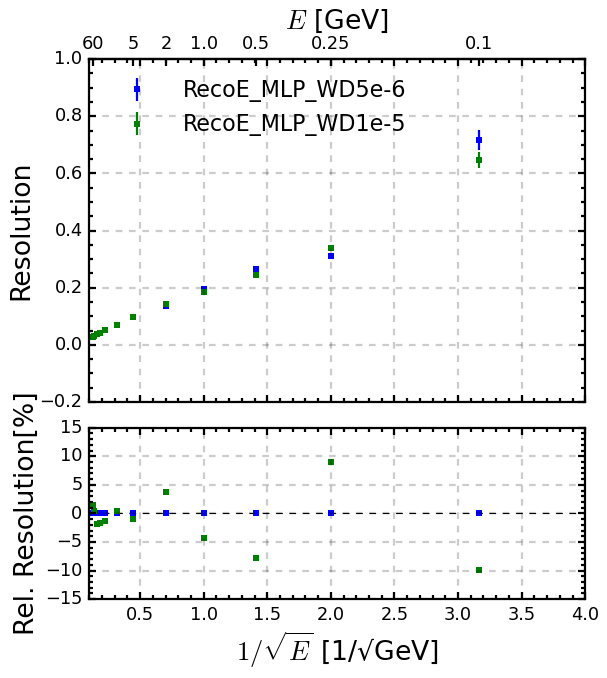

In [65]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(figSize[0], figSize[1]*1.5),
    sharex=True, gridspec_kw={'height_ratios': [1, 0.5], 'hspace': 0.1}
)
MarkerSize = 10

def forward(x):
    return 1 / (x**2)
def inverse(E):
    return 1 / np.sqrt(E)
secax = ax1.secondary_xaxis("top", functions=(forward, inverse))
secax.set_xlabel(r"$E$ [GeV]")
E_ticks = [0.1, 0.25, 0.5, 1.0, 2, 5, 60]
secax.set_xticks(E_ticks)
secax.set_xticklabels(E_ticks)
secax.xaxis.set_minor_locator(plt.NullLocator())
secax.xaxis.set_tick_params(which='both', top=True, labeltop=True, bottom=False, labelbottom=False)

x_ref = 1 / np.sqrt(particleEnergy[0])
y_ref = np.array(resGamma[0])
y_ref_err = np.array(resGammaErr[0])

for i_c in range(len(Config)):
    x_vals = 1 / np.sqrt(particleEnergy[i_c])
    y_vals = np.array(resGamma[i_c])
    y_errs = np.abs(np.array(resGammaErr[i_c]))
    ax1.errorbar(x_vals, y_vals, yerr=y_errs,
                 fmt='s', capsize=4, label=Config[i_c],
                 color=colors[i_c])
ax1.set_ylabel("Resolution")
#ax1.set_title("Resolution of photons")
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.2)
ax1.set_xlim(0.1, 4)
for i_c in range(len(Config)):
    x_vals = 1 / np.sqrt(particleEnergy[i_c])
    y_vals = np.array(resGamma[i_c])
    y_errs = np.abs(np.array(resGammaErr[i_c]))
    print(f"Config: {Config[i_c]}")
    print(f"y_vals: {y_vals}")
    if i_c == 0:
        ax2.errorbar(x_vals, np.zeros_like(y_vals), yerr=0,
                     fmt='s', capsize=4, label=f"{Config[i_c]} (ref)",
                     color=colors[i_c])
    else:
        residual = (y_vals - y_ref) / y_ref
        residual_err = np.sqrt((y_errs / y_ref)**2 + (y_ref_err * y_vals / y_ref**2)**2)
        ax2.errorbar(x_vals, residual * 100, yerr=0,
                     fmt='s', capsize=4, label=f"{Config[i_c]} / {Config[0]} - 1",
                     color=colors[i_c])

ax2.axhline(0, color='black', lw=1, linestyle='--')
ax2.set_xlabel(r"$1/\sqrt{E}$ [1/√GeV]")
ax2.set_ylabel("Rel. Resolution[%]")
#ax2.set_ylim(-20, 20)
ax2.grid(True, linestyle='--', alpha=0.2)
plt.show()